# Create Airbnb price suggestion tool for new hosts using machine learning

**Amanda Wahlers**

Goal: Use machine learning to create a tool that suggests a listing price for new Airbnb hosts based on the prices and characteristics of other listings in their market. 

Task: Supervised ML, regression - Predict listing price using features that would be available to a new host and use these to generate suggested pricing for new listings. 

Dataset: Bozeman, Montana, US; 10 August, 2023; downloaded from Inside Airbnb @ https://insideairbnb.com/get-the-data/

This notebook contains: 
1. Data cleaning: Extracting numeric features from strings, subsetting dataset to target listings (non-institutional host, non-luxury), dealing appropriately with missing values. 
2. Feature engineering: Using my domain knowledge and insights from exploratory analysis to extract important amenities, create sensible listing types (house, apt, guest house, private room), and interact these listing types with key characteristics that predict price.
3. Set up pipelines to tune and train regularized regression (Lasso, Ridge, Elastic Net) and tree ensemble (Random Forest, Gradient Boosting Regressor, XGBoost Regressor) algorithms with embedded feature selection.
4. Train models, calculate performance metrics, & choose the best model. 

This is a streamlined, "production-ready" version of the code I wrote to arrive at these results, exlcuding many data visualizations and print statements to better understand the data.
The accompanying raw code file, as well as a "production-ready" version of the exploratory analysis, can be found in the companion notebooks in this folder.

Results: The best model was able to predict the price with a mean absolute error of $53 and an R^2 suggesting that it captured 70% of the variation in the data.

## Library Imports

In [3]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Goepandas for GIS
import geopandas as gpd

# Matplotlib for visualization
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns
sns.set_style('white')

# Import function to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Import functions for standardization
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Import function for creation model pipeline
from sklearn.pipeline import make_pipeline

# Import regularized regression algorithms
from sklearn.linear_model import Lasso, Ridge, ElasticNet

# Import tree ensemble algorithms
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Import helper function for cross-validation
from sklearn.model_selection import GridSearchCV

# Import performance metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Import error warning
from sklearn.exceptions import NotFittedError

# Import function to save model
import pickle

## Data Cleaning

Data cleaning first because almost all useful features need to be made numeric before exploratory analysis. 

In [5]:
# Read in dataset
listings = pd.read_csv('Data/August_2023/listings_detail.csv',index_col='id')

In [6]:
# Drop duplicate observations
listings = listings.drop_duplicates()

# Drop features for which all values are missing
listings.dropna(axis="columns", how="all", inplace=True)

# Subset to features that are relevant to the task at hand
listings = listings[['latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 
                     'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'host_is_superhost',
                     'instant_bookable', 'minimum_minimum_nights', 'calculated_host_listings_count']]

In [7]:
# Convert objects that should be numeric types

# Bathrooms (string containing number -> float)
listings.bathrooms_text.replace('Half-bath', '0.5 baths', inplace=True)
listings['bathrooms'] = listings['bathrooms_text'].str.split(' ').str[0].astype(float)
listings[['bathrooms', 'bathrooms_text']].head(20)

# Price (string -> float)
listings['price_str'] = listings['price'].copy()
listings['price'] = listings['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
listings[['price', 'price_str']].head()

# Instant bookable (str -> int)
listings['instant_bookable'] = (listings['instant_bookable'] == 't').astype(int)

# Bedrooms (string -> int)
listings['bedrooms'] = listings['bedrooms'].astype('Int64')
listings.groupby('room_type').bedrooms.value_counts() 
listings.bedrooms.fillna(0, inplace=True) # Seems likely that this indicates 0 "bedroooms" (studio, private room, tent, etc)
listings['bedrooms'] = listings['bedrooms'].astype(int)

# Beds (fill in a few missing beds with the # of bedrooms - there must be at least 1 bed(ish thing) in a 1 bedroom space)
listings.beds.fillna(listings.bedrooms, inplace=True) 

# Superhost status (string -> int)
listings['host_is_superhost'] = (listings['host_is_superhost'] == 't').astype(int)

In [8]:
# Aim tool at non-luxury stays, so drop any listings over the 98th percentile in price
listings.price.describe().transpose()
p = listings.price.quantile(0.97)
listings = listings[listings['price'].between(1, p)]

## Feature Engineering 
Here I engineer two key features that I suspect will provide useful information for predicting listing price: \
\
**Listing type:** House, Apt/condo/townhouse, Guest suite/house, Private room \
This is useful because property type is too detailed for this relatively small market and room type is too general. \
**Key amenities:** Hot tub, wifi, air conditioning, pet-friendliness, kitchen, ...etc.\
**Attributes x listing type:** Attributes should be more predictive of price within a listing type than across \
For example: AC > no AC; but also AC in a house > no AC in a house > AC in  a private room

### 1. Group listings into useful listing types: 
House, apt/condo/townhouse, guest suite/house, private room

In [11]:
# Assign useful listing-type groups based on domain knowledge and shared characteristics (# of bedrooms, price) in this market 
listings['listing_type'] = listings['property_type'].copy()
listings['listing_type'].replace(['Entire home', 'Entire townhouse', 'Entire bungalow', 'Entire chalet', 'Entire cabin', 'Entire vacation home'], 'house', inplace=True)
listings['listing_type'].replace(['Entire condo', 'Entire rental unit'], 'apt', inplace=True)
listings['listing_type'].replace(['Entire guesthouse', 'Entire guest suite', 'Entire cottage', 'Entire loft', 'Entire place'], 'guest_suite', inplace=True)
listings['listing_type'].replace(['Private room in home', 'Private room in townhouse', 'Private room in rental unit', 
                          'Private room in guesthouse', 'Private room in bed and breakfast', 
                          'Private room in condo', 'Private room in guest suite', 'Camper/RV', 'Tent'], 'private_room', inplace=True)

# Drop types of properties that will be outside the scope of the tool or are unable to be predicted in this market
# Hotel rooms & luxury serviced apartments (would likely have institutional hosts), & shared rooms (too few listings)
listings = listings[~listings.property_type.isin(['Entire serviced apartment','Room in boutique hotel',
                                               'Room in hostel','Shared room in hostel'])]

### 2. Create indicators for key amenities: 
Kitchen, hot tub, wifi, air conditioning, pet-friendliness, ...etc.

In [13]:
# Create indicators for amenities that may help predict price
listings['amenities'] = listings.amenities.str.lower()
amenities_list = ['wifi', 'hot tub', '\"kitchen\"', 'tv', 'coffee', '\"washer\"|\"free washer', '\"dryer\"|free dryer', 
                  'backyard', '\"pets allowed\"', 'workspace', 'pool', 'fire pit', 'bbq', 
                  'window ac|air conditioning|ac - split', 'free parking', 'dishwasher', 'gym', 'self check-in', 'stove', 'view',
                 'patio', 'crib'] 
for amenity in amenities_list:
    listings[amenity] = listings['amenities'].str.contains(amenity).astype(int)

# Engineer feature for total number of important amenities at each property (keeping in mind some amenities are worth more than others)
listings['total_amenities'] = listings[amenities_list].sum(axis=1)

# View share of listings with each amenity
listings[amenities_list].mean()

# Rename amenities to remove special characters
listings = listings.rename(columns={'\"kitchen\"': 'kitchen', '\"washer\"|\"free washer': 'washer', '\"dryer\"|free dryer': 'dryer',
                         '\"pets allowed\"': 'pets allowed', 'window ac|air conditioning|ac - split': 'ac'}, errors='raise')

### 3. Other feature engineering
Ensure there aren't any sparse classes (aggregate, flag, or censor where appropriate), create interactions between variables, and engineer any misc. features that might help predict price.

In [15]:
# Create log price (helpful since price is right tailed)
listings['log_price'] = np.log10(listings.price)

In [16]:
# Generate indicator that listing is located downtown
listings['downtown'] = (listings.longitude.between(-111.06,-111.02) & listings.latitude.between(45.66, 45.69)).astype(int)

In [17]:
# Create indicator that property only accepts long stays (28+ days) 
listings['long_stays_only'] = (listings.minimum_minimum_nights >=28).astype(int)

In [18]:
# Generate polar coordinates from lat, long (more helpful to ML algos than cartesian coords)
def polarcoords(long, lat):
    z = long + lat * 1j
    rho, theta = np.abs(z), np.angle(z)

    return rho, theta

# Call function and store polar coordinates
listings['rho'],listings['theta'] = polarcoords(listings.longitude, listings.latitude)

In [19]:
# Max # of guests (rename)
listings['max_guests'] = listings['accommodates'].copy()

In [20]:
# Total number of bedrooms + bathrooms (beds & baths are some of the features most correlated with price in this data)
listings['bedroom_and_bath'] = listings['bedrooms'] + listings['bathrooms']

In [21]:
# Ratio of bedrooms to bathrooms
listings['baths_per_bedroom'] = listings['bathrooms']/listings['bedrooms']
listings.loc[listings.baths_per_bedroom > 10, 'baths_per_bedroom'] = 1.0  # get rid of pesky infinities for 0 bedrooms

In [22]:
# Create squared & cubed terms for features that are highly correlated with price to help capture non-linear effects 
features = ['max_guests', 'bathrooms', 'beds', 'bedrooms', 'bedroom_and_bath', 'baths_per_bedroom']

for f in features:
    listings['{}_sq'.format(f)] = listings[f] * listings[f]
    listings['{}_cu'.format(f)] = listings[f] * listings[f] * listings[f]

In [23]:
# Create indicator for 3+ listings ('job' rather than 'side hustle')
listings['three_plus_listings']  = (listings.calculated_host_listings_count > 2).astype(int)

### 4. Interaction terms: Attributes x listing type
Within each listing type (private room, guest house, apartment, house), there are likely to be amenities or features that increase the price within that type of listing, but this relationship does not necessarily hold across types. For example, a house with AC would probably be priced higher than a house without AC, but a private room with AC would not be priced higher than a house without AC.

In [25]:
# Interact key features with listing type 

# Create dummies for listing type and keep the original column
listings2 = pd.get_dummies(listings, columns=['listing_type'], dtype=int)
listings2['listing_type'] = listings['listing_type'].copy()
listings  = listings2.copy() 

# Create two lists: one of listings types, one of features
type_list    = ['listing_type_apt','listing_type_guest_suite', 'listing_type_house', 'listing_type_private_room']
feature_list = ['max_guests', 'bedrooms', 'bathrooms', 'ac', 'kitchen', 'pets allowed', 'downtown']

# Interact features x listing types
for f in feature_list:
    for m in type_list:
        listings['{}_{}'.format(m,f)] = listings[m]*listings[f]

### 5. Save analytical base table

In [27]:
# Create analytical base table with features that will go into the model
abt = listings[['bedrooms', 'beds', 'price', 'log_price', 'instant_bookable','bathrooms','wifi', 
                    'hot tub', 'kitchen', 'tv', 'coffee', 'washer', 'dryer', 'backyard', 
                    'pets allowed', 'workspace', 'pool', 'fire pit', 'bbq', 'ac', 
                    'free parking', 'dishwasher', 'gym', 'self check-in', 'stove', 'view', 'patio', 
                    'crib', 'total_amenities', 'rho', 'theta', 'downtown', 'long_stays_only', 
                    'max_guests', 'bedroom_and_bath', 'baths_per_bedroom', 'max_guests_sq', 
                    'bathrooms_sq', 'beds_sq', 'bedrooms_sq','bedroom_and_bath_sq', 'baths_per_bedroom_sq',
                    'listing_type_apt_max_guests', 'listing_type_guest_suite_max_guests',
                   'listing_type_house_max_guests', 'listing_type_private_room_max_guests',
                    'listing_type_apt', 'listing_type_guest_suite', 'listing_type_house', 'listing_type_private_room', 
                    'listing_type_apt_bedrooms', 'listing_type_guest_suite_bedrooms', 'max_guests_sq', 'max_guests_cu',
                    'listing_type_house_bedrooms', 'listing_type_private_room_bedrooms',
                    'listing_type_apt_bathrooms', 'listing_type_guest_suite_bathrooms',
                    'listing_type_house_bathrooms', 'listing_type_private_room_bathrooms',
                    'listing_type_apt_ac', 'listing_type_guest_suite_ac', 'listing_type_house_ac', 'listing_type_private_room_ac',
                    'listing_type_apt_kitchen', 'listing_type_guest_suite_kitchen','listing_type_house_kitchen', 
                    'listing_type_private_room_kitchen','listing_type_apt_pets allowed','listing_type_guest_suite_pets allowed',
                    'listing_type_house_pets allowed','listing_type_private_room_pets allowed', 'listing_type_apt_downtown',
                    'listing_type_guest_suite_downtown', 'listing_type_house_downtown', 'bathrooms_sq',
                    'bathrooms_cu', 'beds_sq', 'beds_cu', 'bedrooms_sq', 'bedrooms_cu',
                    'bedroom_and_bath_sq', 'bedroom_and_bath_cu', 'baths_per_bedroom_sq',
                    'baths_per_bedroom_cu', 'listing_type_private_room_downtown']].copy()

In [28]:
# Assert no missing values remain
assert all(listings.isna().sum()) == 0

In [29]:
# Assert all features are numeric
assert all(abt.dtypes.map(pd.api.types.is_numeric_dtype)) == True

In [30]:
# Save data
abt.to_csv('Data/abt.csv', index=None)

## Algorithm Selection

Split data into train and test sets. Set up pipelines for regularized regression (parametric) and tree ensemble algorithms (non-parametric). Initialize hyperparameter grids, which will enable algorithms to perform embedded feature selection. 

In [32]:
# Load abt
abt = pd.read_csv('Data/abt.csv')

In [33]:
# Split data into taining and test sets
y = abt.log_price
X = abt.drop(columns=['price', 'log_price'], axis=1)

s = 987
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=s) 

In [34]:
# Create pipelines dictionary
pipelines = {
    # Regularized regression algorithms
    'lasso' : make_pipeline(StandardScaler(), Lasso(random_state = s)),
    'ridge' : make_pipeline(StandardScaler(), Ridge(random_state = s)),
    'enet'  : make_pipeline(StandardScaler(), ElasticNet(random_state=s)),
    # Tree ensemble algorithms
    'rf'    : make_pipeline(StandardScaler(), RandomForestRegressor(random_state=s)),
    'gb'    : make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=s)),
    'xgb'   : make_pipeline(StandardScaler(), XGBRegressor(random_state=s))
}

# Declare hyperparameters to tune
lasso_hp = {
    'lasso__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
}
ridge_hp = {
    'ridge__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
}
enet_hp = {
    'elasticnet__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]
}
rf_hp = {
    'randomforestregressor__n_estimators': [100, 200],
    'randomforestregressor__max_features': [1, 'sqrt', 0.33]
}
gb_hp = {
    'gradientboostingregressor__n_estimators' : [100, 200],
    'gradientboostingregressor__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [1, 3, 5]
}   
xgb_hp = {
    'xgbregressor__n_estimators' : [100, 200],
    'xgbregressor__learning_rate': [0.05, 0.1, 0.2],
    'xgbregressor__max_depth': [1, 3, 5]
}   

# Compile hyperparameter grids into single dictionary
hyperparameters = {
    'lasso' : lasso_hp,
    'ridge' : ridge_hp,
    'enet'  : enet_hp,
    'rf'    : rf_hp,
    'gb'    : gb_hp,
    'xgb'   : xgb_hp
}

In [35]:
# Check that hyperparameter grid was created correctly
for key in ['lasso', 'ridge', 'enet', 'rf', 'gb', 'xgb']:
    if key in hyperparameters:
        if type(hyperparameters[key]) is dict:
            print( key, 'was found in hyperparameters and is a grid.' )
        else:
            print( key, 'was found in hyperparameters, but it is not a grid.' )
    else:
            print( key, 'was not found in hyperparameters')

lasso was found in hyperparameters and is a grid.
ridge was found in hyperparameters and is a grid.
enet was found in hyperparameters and is a grid.
rf was found in hyperparameters and is a grid.
gb was found in hyperparameters and is a grid.
xgb was found in hyperparameters and is a grid.


## Model Training

Tune hyperparameters and calculate performance metrics. Pick a best model.

In [37]:
# Create empty dictionaries to store output
fitted_models = {}
feature_importance = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Define model
    model = GridSearchCV(pipeline, hyperparameters[name], cv= 10, n_jobs = -1)

    # Fit model
    model.fit(X_train, y_train)

    # Store model in dictionary
    fitted_models[name] = model

    # Print
    print(name, 'has been fitted')

lasso has been fitted
ridge has been fitted


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.995e-02, tolerance: 1.841e-03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.945e-01, tolerance: 1.885e-03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.328e-01, toler

enet has been fitted
rf has been fitted
gb has been fitted
xgb has been fitted


In [38]:
# Check that models were sucessfully fitted
for name, model in fitted_models.items():
    try:
        pred = model.predict(X_test)
        print(name, 'has been fitted.')
    except NotFittedError as e:
        print(repr(e))

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.
xgb has been fitted.


In [39]:
# Display performance metrics for each model
for key, model in fitted_models.items():
    pred = model.predict(X_test)
    print(key)
    print('----') 
    print('R^2:', r2_score(y_test,pred))
    print('MAE:', mean_absolute_error(10**y_test,10**pred))
    print()

lasso
----
R^2: 0.6556574177922558
MAE: 56.42536924380449

ridge
----
R^2: 0.7145584249590258
MAE: 53.25027708792959

enet
----
R^2: 0.65946740739631
MAE: 56.05181643940476

rf
----
R^2: 0.6589920152820123
MAE: 55.95522866344103

gb
----
R^2: 0.6683483486550656
MAE: 55.46700110827511

xgb
----
R^2: 0.6570221124940541
MAE: 56.62245546068467



In [83]:
# Choose the best model
best = 'ridge'

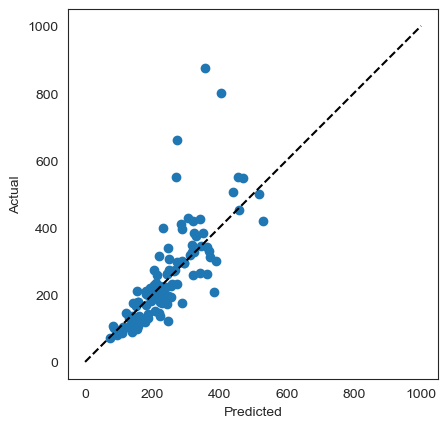

In [85]:
# Plot performance of winning model
pred = fitted_models[best].predict(X_test)
plt.scatter(10**pred, 10**y_test)
plt.plot( [0,1000], [0,1000], linestyle='--', color='k' )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.axis('square')
plt.show()

In [87]:
# Display best pipeline - hyperparameter values
fitted_models[best].best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=10, random_state=987))])

In [89]:
# Save best pipeline object
with open('final_model.pkl','wb') as f:
    pickle.dump(fitted_models[best].best_estimator_, f)

## Insights & Analysis

Results: The ridge regression eeked out the best performance with a mean absolute error of $53 and an R^2 suggesting the model was able to capture 71% of the variation in the data. Not too shabby! This model would probably perform even better in a larger city setting where neighborhoods and proximity to desirable locations vary more than they do in Bozeman. This project taught me a lot about the importance of domain knowledge and feature engineering. While there was a lot of useful raw information available, it took extensive manipulation, data exploration, and calling on my own experiences as an Airbnb guest and host to creatively engineer features that the algorithms would be able to use to predict listing prices. \
\
If I were to continue working on this, I would love to build something that takes into account other aspects that impact price that would take a bit more work to include. These include seasonality, which could be added to the model using time-series data, cosmetic appeal, which could be brought into the model through image analysis of listing thumbnails, information only provided in the text of a listing (caveats, special notes, rules, etc), which could be brought into the model using NLP, and host preferences (such as a host preferring maximum booked nights (thus willing to drop the price to fill empty days) versus a host who would rather see the listing sit empty than accept an amount less than X due to cleaning or hassle costs), which could be brought into the model through the classification of hosts into types using time-series data.

Theoretical next steps for the implementation of this tool would be to: 
1. Create a generalized version to predict price in any market. \
    I wanted to do a deep dive on Bozeman's Airbnb market that would allow me to understand the kinds of listings that are most common, where listings are located, minimum stays, popular amenities, and what kinds of hosts have listings in Bozeman in connection with another project. Generalizing this tool this would include removing Bozeman-specific data cleaning steps and making them flexible to other markets. For example, neighborhood classifiers would undoubtedly be useful in larger cities - Bozeman's data only had 1 neighborhood - and shared rooms are likely more prevalent in other markets, so could be included - Bozeman only had one shared room listing in this data. To scale this script, I would add more assert checks and more flexible conditional statements to account for differences in the data available in different markets. 
2. Build a user-friendly interface that takes in X key characteristics about a new listing and uses the winning model to suggest a listing price.